We build intuition for how peptidergic connectivity could partition cells into meaningful groups even in the absence of explicit gene expression information with a toy problem.

The type x type adjacency matrix can be sampled to obtain a cell x cell adjacency matrix. The block structure is equivalent to the graph having distinct connected components.

We generate embeddings of these graphs with Spectral graph clustering and Node2Vec to identify such components.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from cci.sim import Interactions
from rich import print as rprint
from torch_geometric.utils import from_scipy_sparse_matrix
import torch
from torch_geometric.nn import Node2Vec
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale=0.8, rc=custom_params)
%config InlineBackend.figure_format="retina"



In [2]:
from sklearn.manifold import TSNE

def showplot(embedding, color):

    z = TSNE(n_components=2).fit_transform(embedding)

    plt.figure(figsize=(3, 3))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=5, c= color, cmap = "Paired")
    plt.show()
    return


for the 0 communication channel:


{0: ['d', 'e', 'f', 'g'], 1: ['a', 'b', 'c', 'h']}

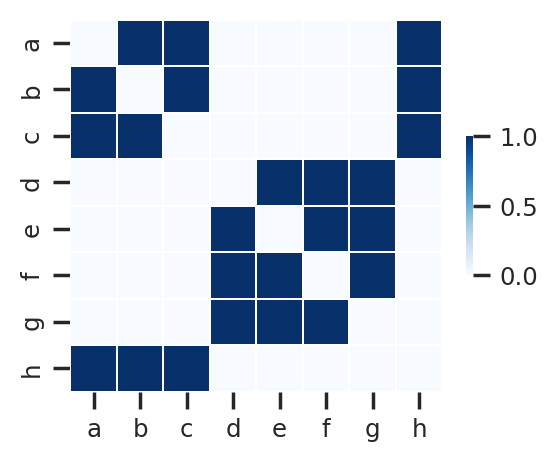

for the 1 communication channel:


{0: ['d', 'e', 'f', 'g'], 1: ['a', 'b', 'c', 'h']}

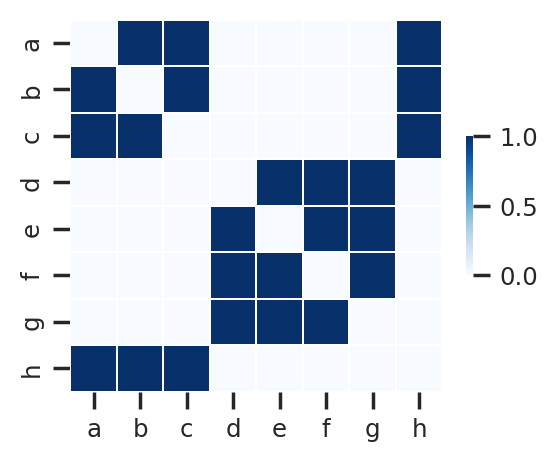

for the 2 communication channel:


{0: ['d', 'f', 'g', 'h'], 1: ['a', 'b', 'c', 'e']}

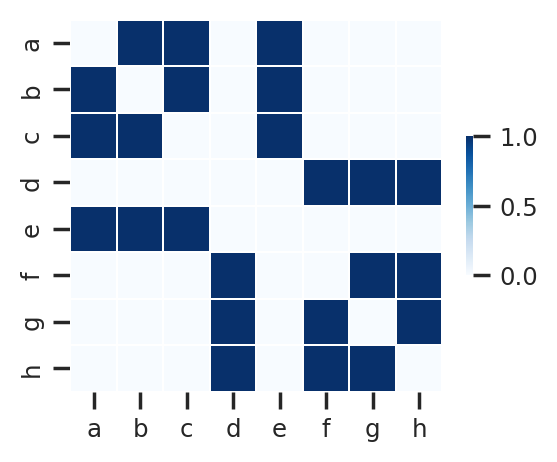

In [3]:
# Used to create simulation data
C = Interactions(n_blocks_per_graph=2, seed=0)

# Get label x label adjacency matrices
b_ch, A_ch = C.get_adj_per_channel()
for ch in range(C.n_channels):
    print(f"for the {ch} communication channel:")
    rprint(b_ch[ch])
    f, ax = plt.subplots(1, 1, figsize=(3, 3))
    sns.heatmap(A_ch[ch],ax=ax, cmap="Blues", cbar_kws={'shrink':0.3}, square=True, linewidths=0.1)
    plt.show()


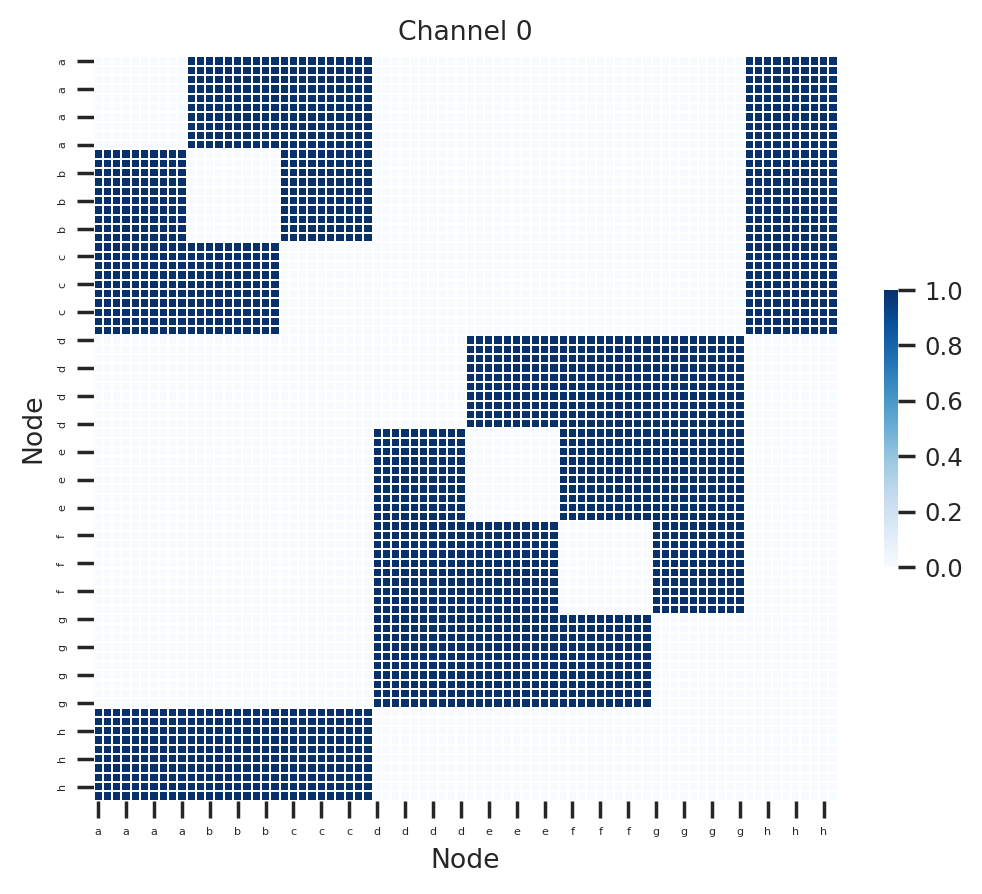

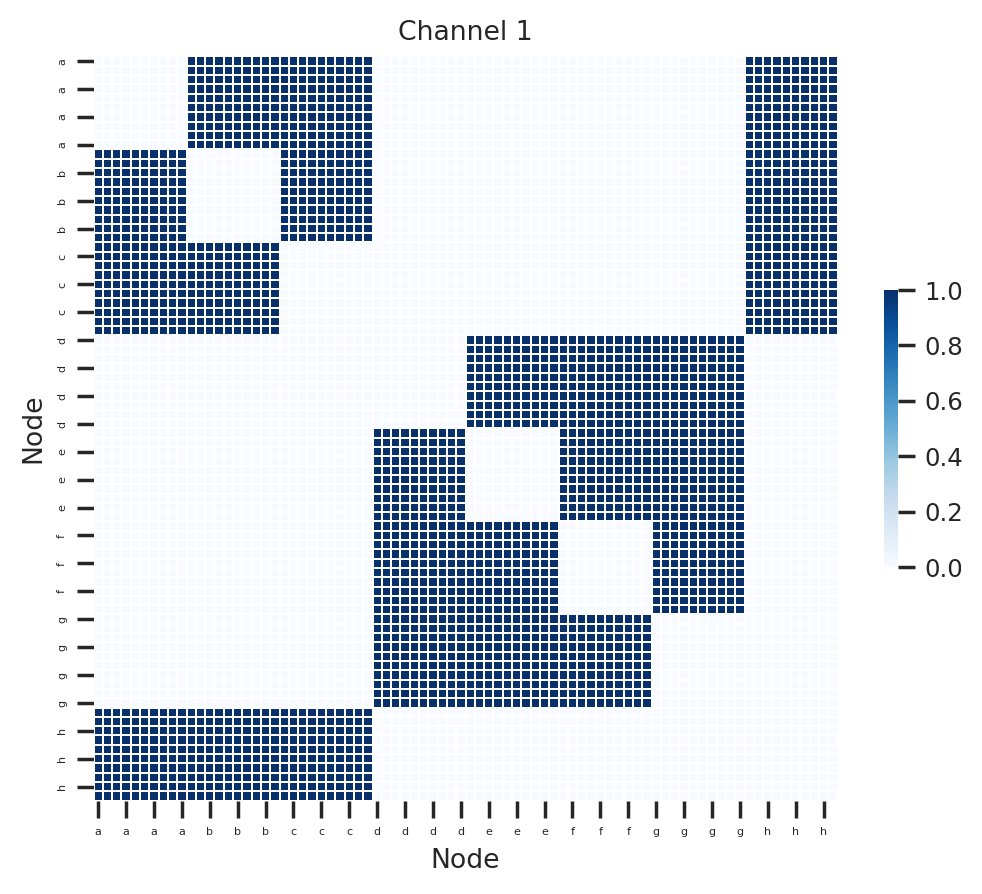

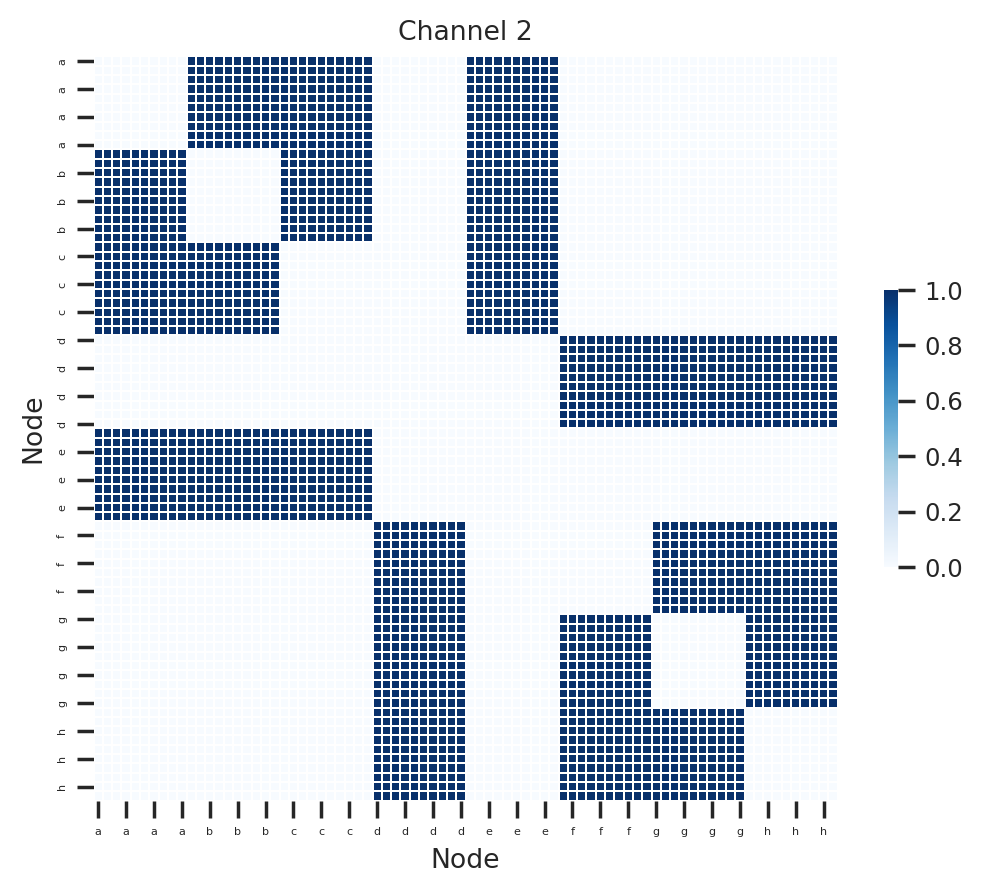

In [4]:
# Get node x node graphs from all channels

adj_list = []
block_labels_list = []
for i in range(C.n_channels):
    node_labels, A = C.get_sample_adj(A_ch[i])
    adj_list.append(A)
    block_labels_list.append(C.get_block_labels(b_ch[i]))
    A = pd.DataFrame(A, index=node_labels, columns=node_labels)

    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    sns.heatmap(A,ax=ax, cmap="Blues", cbar_kws={'shrink':0.3}, square=True, linewidths=0.1)
    ax.set(xlabel="Node", ylabel="Node")
    # make ticks small
    plt.xticks(fontsize=4)
    plt.yticks(fontsize=4)
    plt.title("Channel " + str(i))
    plt.show()

Spectral clustering frames the problem as an eigen decomposition. Specifically, the eigenvectors of the Laplacian matrix are used as features for clustering.


In [5]:
# Use spectral graph clustering to identify distinct connected components
from sklearn.cluster import SpectralClustering
from sklearn import metrics

sc = SpectralClustering(2, affinity='precomputed', n_init=100)
sc.fit(adj_list[0])
adjusted_rand_score = np.round(metrics.adjusted_rand_score(block_labels_list[0], sc.labels_), 2)
mutal_info_score = np.round(metrics.adjusted_mutual_info_score(block_labels_list[0], sc.labels_), 2)
print("Adjusted rand score: ", adjusted_rand_score)
print("Mutual information score: ", mutal_info_score)

Adjusted rand score:  1.0
Mutual information score:  1.0


/allen/programs/celltypes/workgroups/mousecelltypes/Donghyun/envs/miniconda3/envs/pyg/lib/python3.9/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [6]:
# Use Node2Vec to identify distinct connected components

# Generate 3 node x node adjacency matrices
block_member_list = [{0: ['a', 'b', 'c', 'd'], 1: ['e', 'f', 'g', 'h']}, 
                    {0: ['a', 'b', 'g', 'h'], 1: ['e', 'f', 'c', 'd']}, 
                    {0: ['a', 'c', 'e', 'h'], 1: ['b', 'd', 'f', 'g']}]

# Get edge index and node labels from node x node adjacency matrix 

edge_index_list = []
node_labels_list = []
for i in range(len(block_member_list)):
    block_members, A_df = C.make_adj(block_member_list[i])
    node_labels, adj = C.get_sample_adj(A_df)
    adj = torch.tensor(adj, dtype=torch.long)
    edge_index = adj.nonzero().t().contiguous()
    edge_index_list.append(edge_index)
    node_labels_list.append(node_labels)


In [7]:
# Node2vec parameters
p=1.0
q=1.0
embedding_dim=16
walk_length=10
context_size=10
walks_per_node=1
num_nodes=len(C.get_node_labels())
batch_size=128
num_negative_samples=1


In [8]:
# Node2vec model, optimizer, and loader
model = Node2Vec(edge_index_list[0], embedding_dim=embedding_dim, walk_length=walk_length,
        context_size=context_size, walks_per_node=walks_per_node,
        num_negative_samples=num_negative_samples, p=p, q=q, sparse=True)

optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
loader = model.loader(batch_size=batch_size, shuffle=True)


In [9]:
# Train the model 
model.train()
epochs = 500

for epoch in range(epochs):
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw, neg_rw)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    loss = total_loss / len(loader)
    if epoch % 100 == 0:
        print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}', flush=True) 

Epoch: 00, Loss: 3.5575
Epoch: 100, Loss: 1.6243
Epoch: 200, Loss: 1.2236
Epoch: 300, Loss: 1.2037
Epoch: 400, Loss: 1.1506


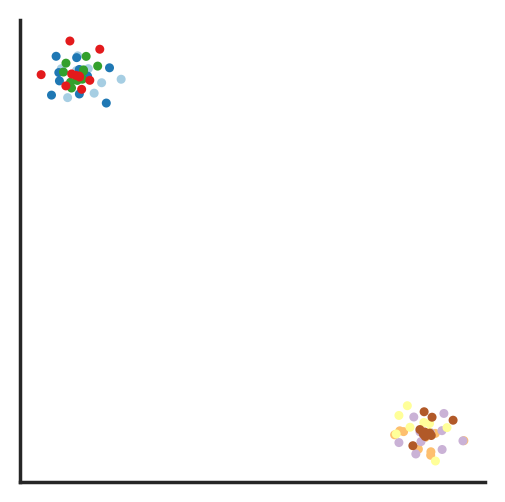

In [10]:
# 1 node2vec embedding from 1 cell x cell graph can identify distinct connected components

embedding1 = model().detach()

showplot(embedding=embedding1, color=[ord(x) for x in node_labels_list[0]])

In [11]:
# Generate 2 more Node2vec embeddings

emb_list = [embedding1]

for i in range(1, 3):
    print("Training embedding " + str(i))
    total_loss = 0
    model = Node2Vec(edge_index_list[i], embedding_dim=embedding_dim, walk_length=walk_length,
        context_size=context_size, walks_per_node=walks_per_node,
        num_negative_samples=num_negative_samples, p=p, q=q, sparse=True)
    optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)
    loader = model.loader(batch_size=batch_size, shuffle=True)
    
    model.train()
    epochs = 500

    for epoch in range(epochs):
        total_loss = 0
        for pos_rw, neg_rw in loader:
            optimizer.zero_grad()
            loss = model.loss(pos_rw, neg_rw)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        loss = total_loss / len(loader)
        if epoch % 100 == 0:
            print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}', flush=True) 

    embedding = model().detach()
    emb_list.append(embedding)

Training embedding 1
Epoch: 00, Loss: 3.9126
Epoch: 100, Loss: 1.5947
Epoch: 200, Loss: 1.2494
Epoch: 300, Loss: 1.2159
Epoch: 400, Loss: 1.1549
Training embedding 2
Epoch: 00, Loss: 3.6309
Epoch: 100, Loss: 1.5108
Epoch: 200, Loss: 1.2434
Epoch: 300, Loss: 1.1483
Epoch: 400, Loss: 1.1549


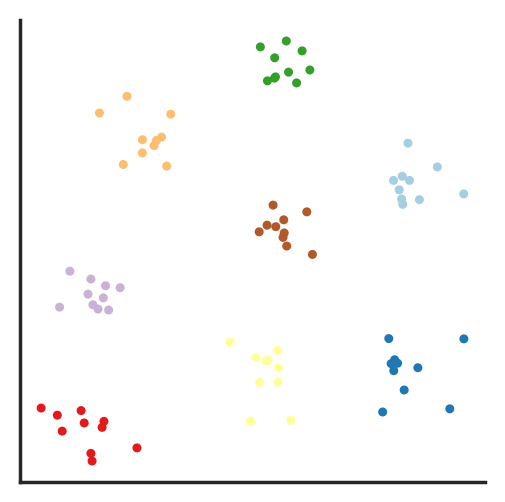

In [12]:
# 3 node2vec embeddings from 3 carefully chosen cell x cell graphs can identify all "types"

combined_embedding = emb_list[0].numpy()
for i in range(1, 3):
    combined_embedding = np.concatenate((combined_embedding, emb_list[i].numpy()), 1)
showplot(embedding=combined_embedding, color=[ord(c) - 97 for c in node_labels])